In [27]:
import sys
sys.path.append("..")
from coefficients import alignment
from utils import helpers
import glob
import numpy as np
from imageio import imread

/tmp/ipykernel_356/1426548864.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 4, figsize=(8, 4))


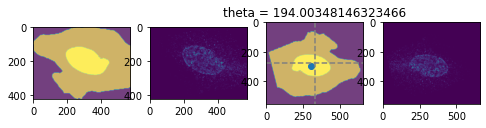

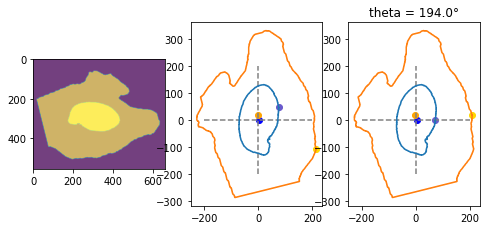

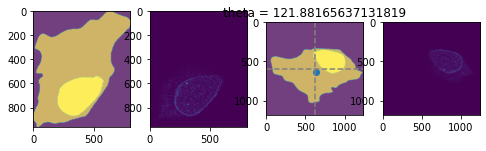

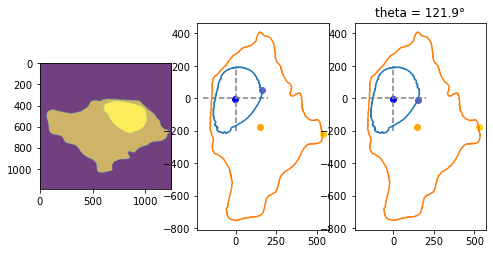

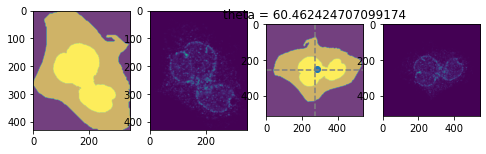

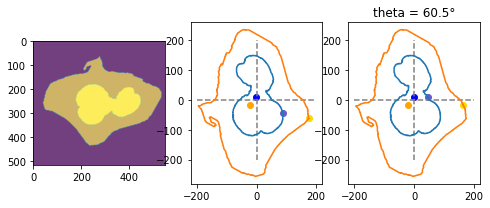

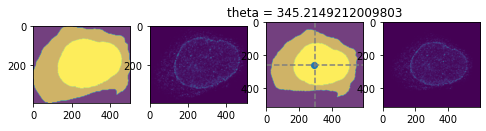

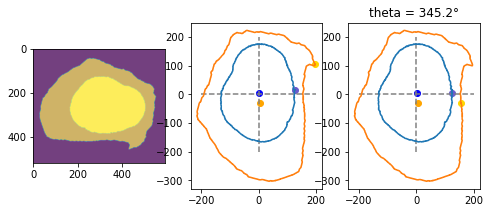

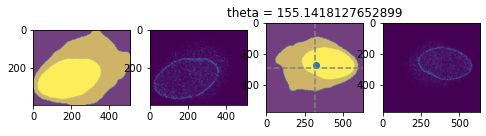

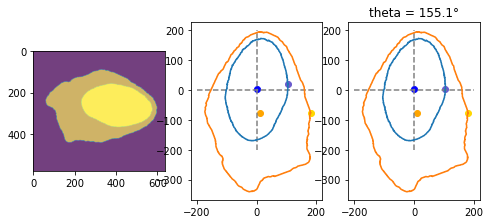

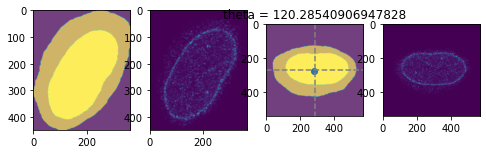

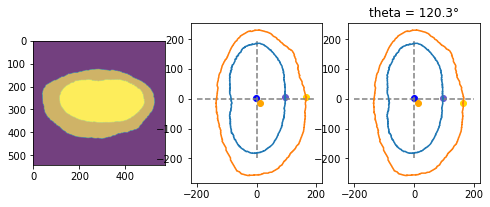

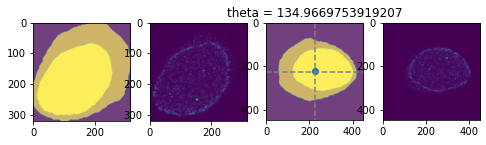

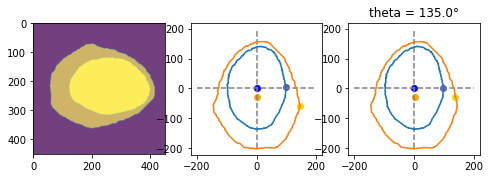

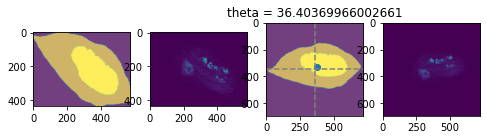

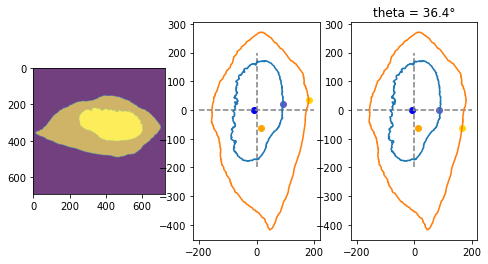

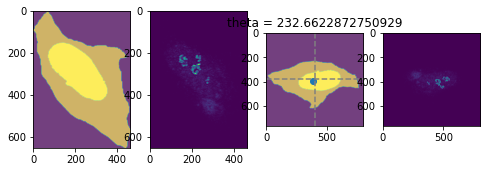

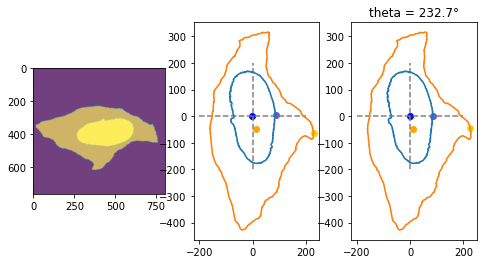

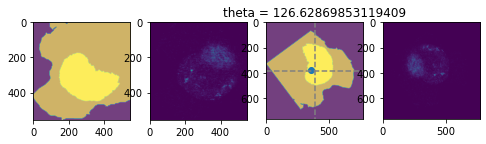

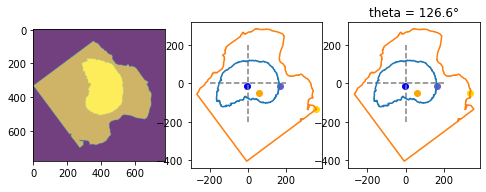

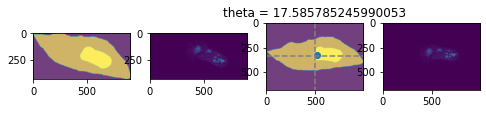

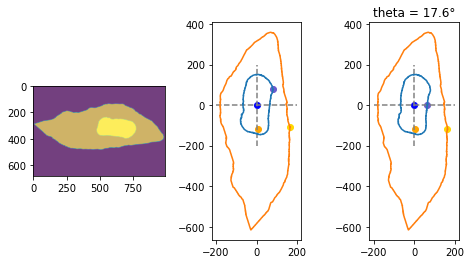

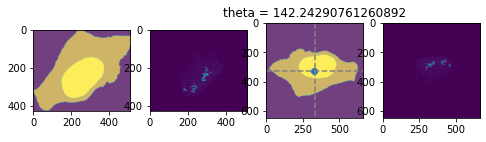

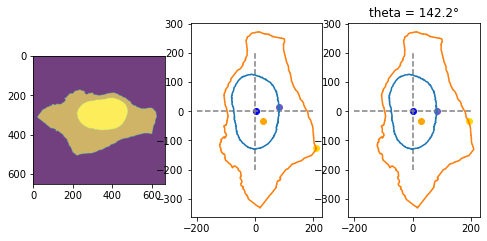

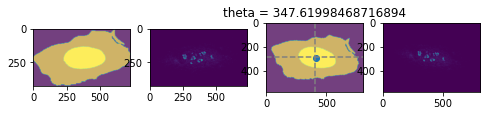

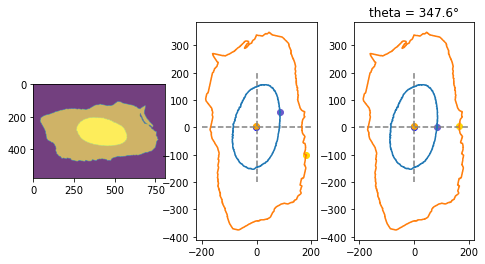

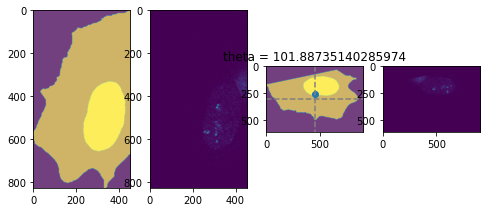

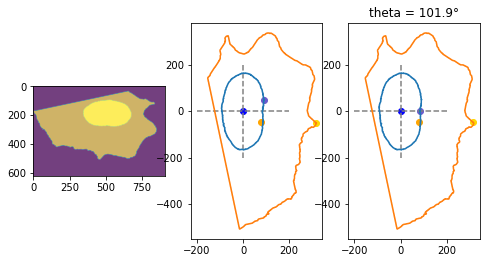

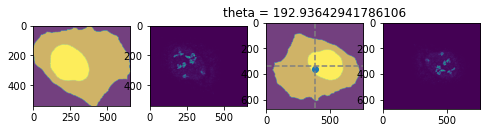

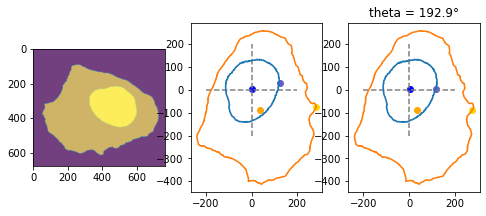

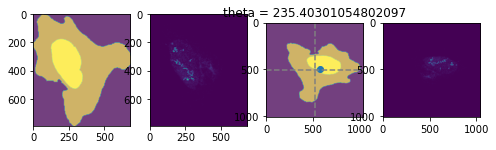

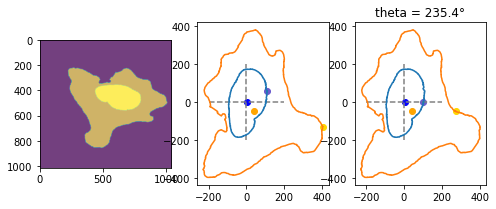

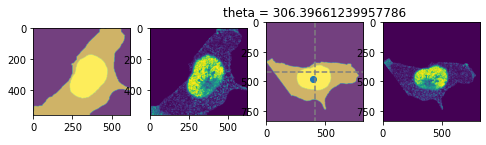

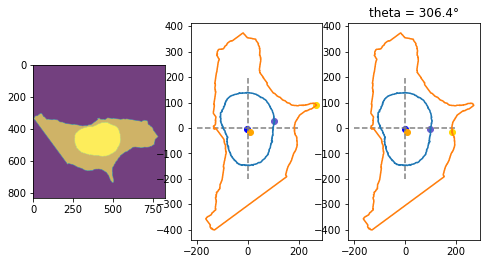

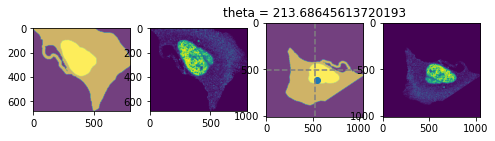

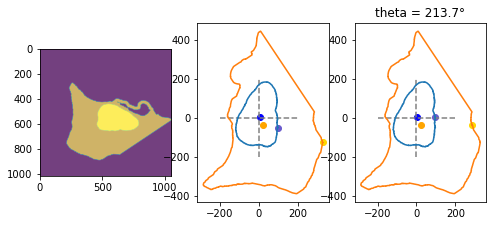

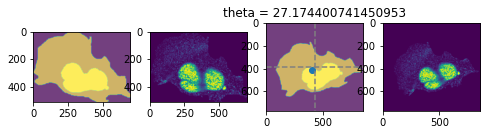

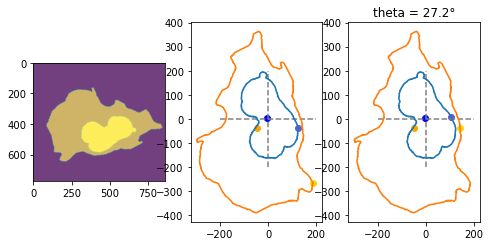

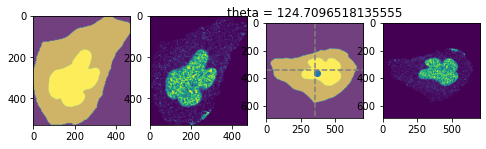

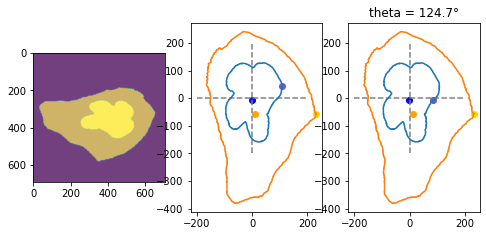

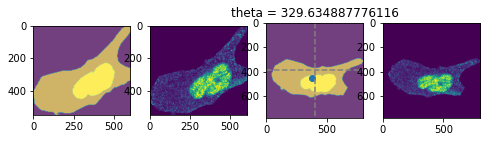

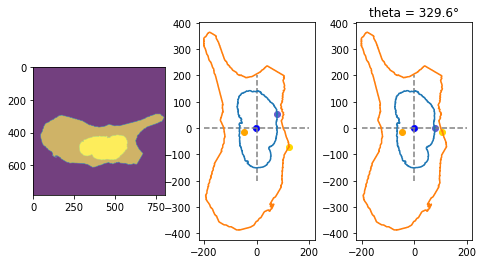

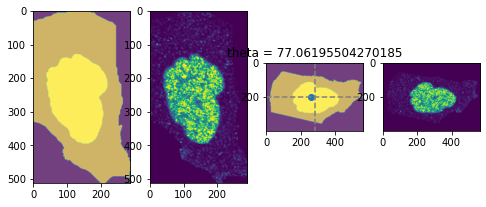

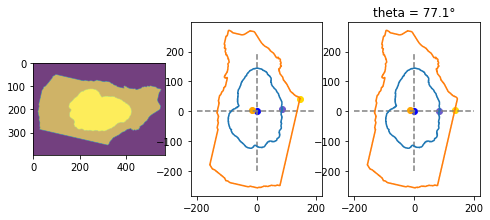

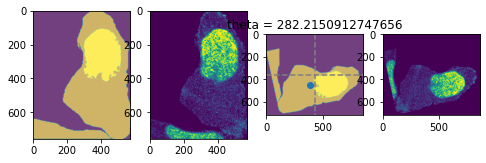

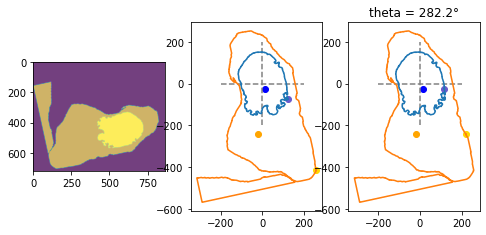

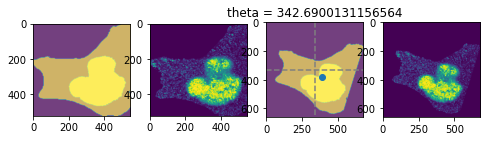

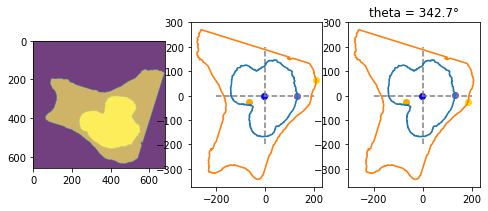

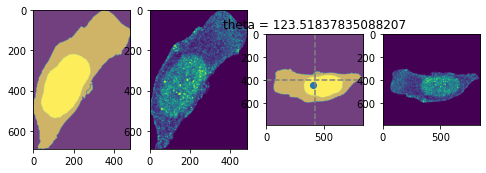

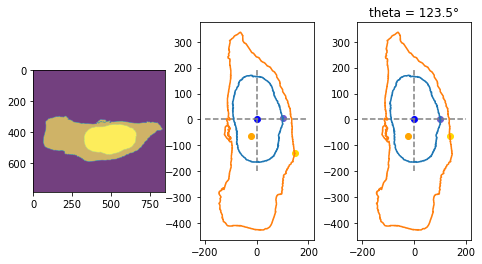

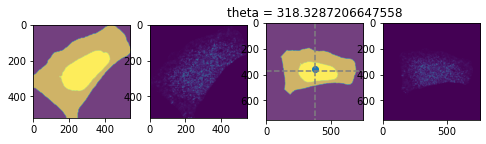

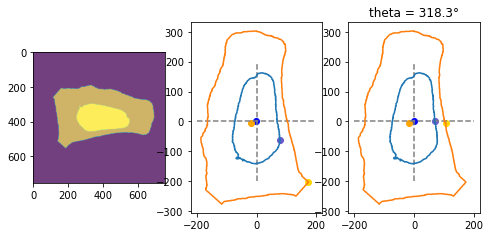

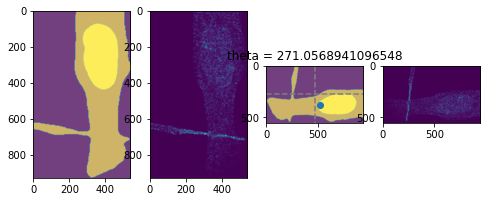

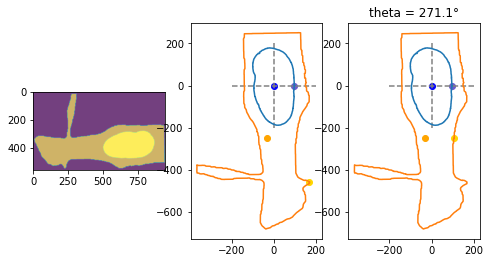

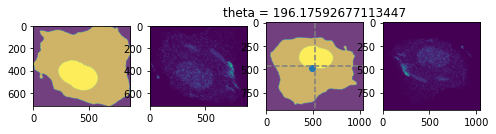

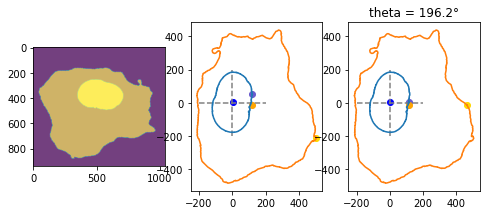

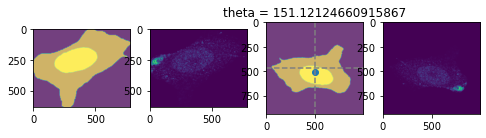

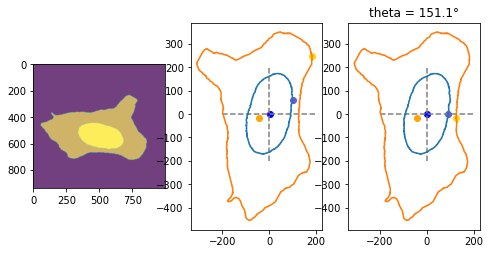

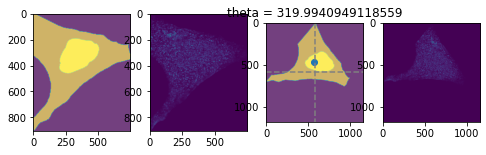

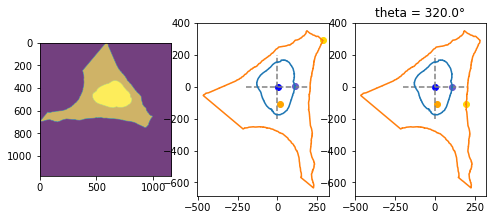

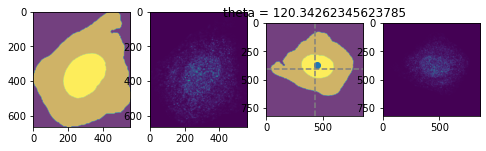

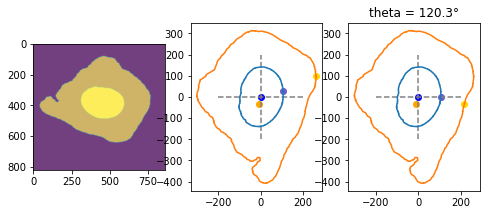

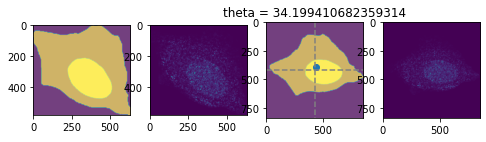

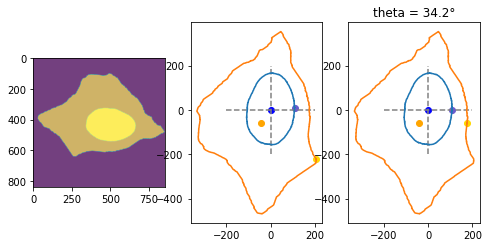

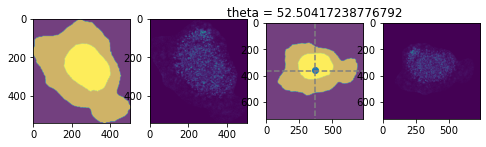

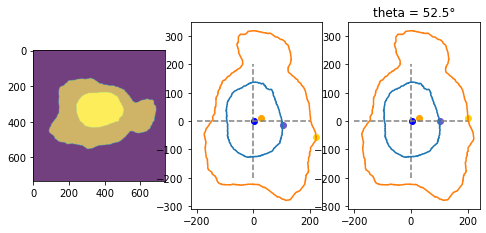

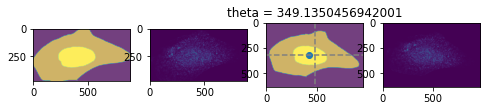

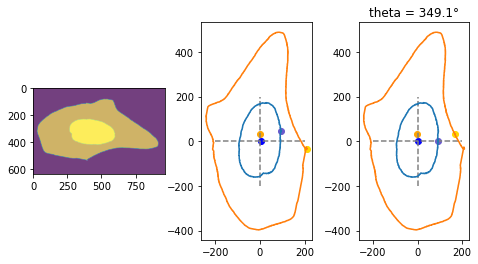

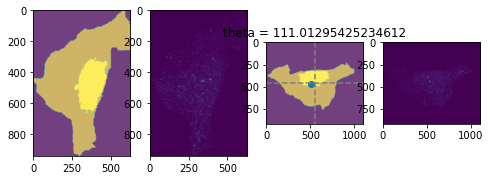

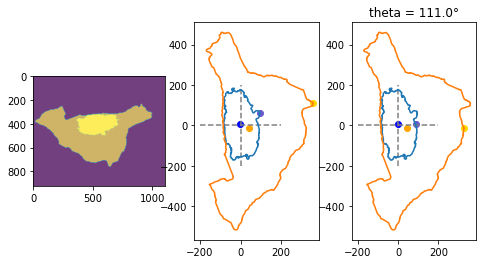

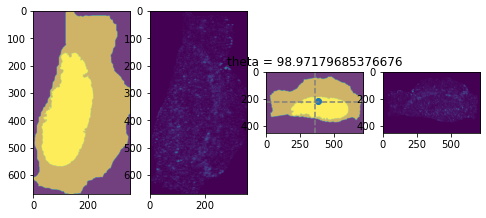

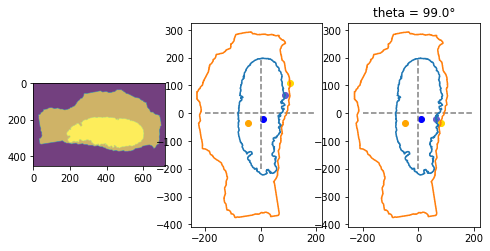

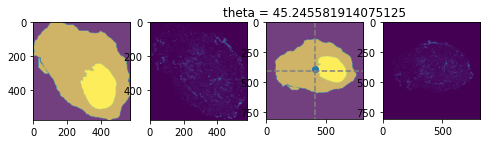

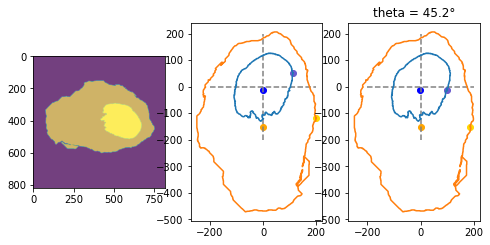

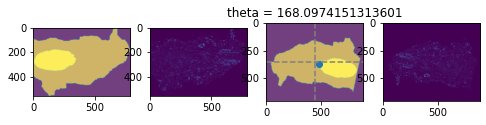

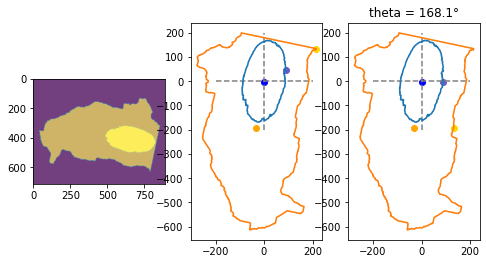

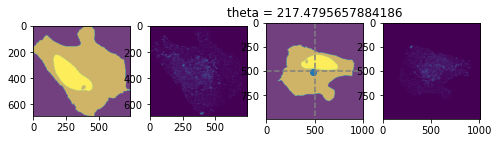

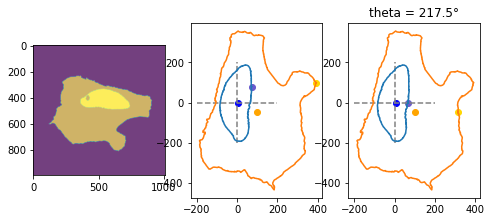

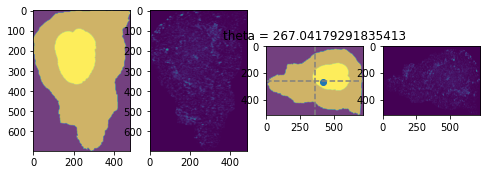

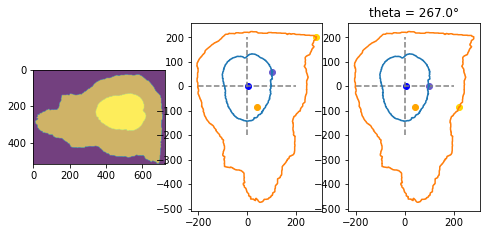

In [168]:
d = "/mnt/c/Users/trang.le/Desktop/shapespace_pilot_data/U2OS_2"
imlist = glob.glob(f"{d}/*.npy")

for im in imlist[45:85]:
    data = np.load(im)
    pro = imread(str(im).replace('.npy', '_protein.png'))
    nuclei_, cell_, theta = align_cell_major_axis_polarized(data, pro, plot=True)
    centroid = center_of_mass(nuclei_)

    # Padd surrounding with 0 so no contour touch the border. This help matching squares algo not failing (as much)
    nuclei = np.zeros((nuclei_.shape[0]+2, nuclei_.shape[1]+2))
    nuclei[1:1+nuclei_.shape[0],1:1+nuclei_.shape[1]] = nuclei_
    cell = np.zeros((cell_.shape[0]+2, cell_.shape[1]+2))
    cell[1:1+cell_.shape[0],1:1+cell_.shape[1]] = cell_

    nuclei_coords_ = find_contours(nuclei)
    if len(nuclei_coords_) > 1: # concatenate fragmented contour lines, original point could be ambiguous! (attempt to re-align original point in coefs.XXX_fourier_coefs())
        # if the biggest contour segment is a close loop, the rest are micronuclei, artifact segments
        idx_longest = np.argmax([len(xy) for xy in nuclei_coords_])
        biggest = nuclei_coords_[idx_longest]
        if all(biggest[0] == biggest[-1]):
            nuclei_coords_ = biggest - centroid
        else:
            nuclei_coords_ = np.vstack(nuclei_coords_)
            nuclei_coords_ = nuclei_coords_ - centroid
    else:
        nuclei_coords_ = nuclei_coords_[0] - centroid

    cell_coords_ = find_contours(cell)
    if len(cell_coords_) > 1: # concatenate fragmented contour lines, original point could be ambiguous! (attempt to re-align original point in coefs.XXX_fourier_coefs())
        # if the biggest contour segment is a close loop, the rest are micronuclei, artifact segments
        idx_longest = np.argmax([len(xy) for xy in cell_coords_])
        biggest = cell_coords_[idx_longest]
        if all(biggest[0] == biggest[-1]):
            cell_coords_ = biggest - centroid
        else:
            cell_coords_ = np.vstack(cell_coords_)
            cell_coords_ = cell_coords_ - centroid
    else:
        cell_coords_ = cell_coords_[0] - centroid

    cell_coords = cell_coords_.copy()
    cell_coords = helpers.realign_contour_startpoint(cell_coords)
    nuclei_coords = nuclei_coords_.copy()
    nuclei_coords = helpers.realign_contour_startpoint(nuclei_coords)
    if True:
        fig, ax = plt.subplots(1, 3, figsize=(8, 4))
        ax[0].imshow(nuclei, alpha=0.5)
        ax[0].imshow(cell, alpha=0.5)
        
        nu_centroid = helpers.find_centroid(nuclei_coords)
        cell_centroid = helpers.find_centroid(cell_coords)
        ax[1].plot(nuclei_coords_[:, 0], nuclei_coords_[:, 1])
        ax[1].scatter(nuclei_coords_[0, 0], nuclei_coords_[0, 1], color="slateblue")
        ax[1].scatter(nu_centroid[0], nu_centroid[1], color="b")
        ax[1].plot(cell_coords_[:, 0], cell_coords_[:, 1])
        ax[1].scatter(cell_coords_[0, 0], cell_coords_[0, 1], color="gold")
        ax[1].scatter(cell_centroid[0], cell_centroid[1], color="orange")
        
        ax[1].vlines(0, -200, 200, colors='gray', linestyles ='dashed') 
        ax[1].hlines(0, -200, 200, colors='gray', linestyles ='dashed')
        ax[1].axis("scaled")
        ax[2].set_title(f"theta = {np.round(theta,1)}°")
        ax[2].vlines(0, -200, 200, colors='gray', linestyles ='dashed') 
        ax[2].hlines(0, -200, 200, colors='gray', linestyles ='dashed')
        ax[2].plot(nuclei_coords[:, 0], nuclei_coords[:, 1])
        ax[2].scatter(nuclei_coords[0, 0], nuclei_coords[0, 1], color="slateblue")
        ax[2].scatter(nu_centroid[0], nu_centroid[1], color="b")
        ax[2].plot(cell_coords[:, 0], cell_coords[:, 1])
        ax[2].scatter(cell_coords[0, 0], cell_coords[0, 1], color="gold")
        ax[2].scatter(cell_centroid[0], cell_centroid[1], color="orange")
        ax[2].axis("scaled")
        #plt.savefig(f"{save_dir}/{os.path.basename(im)}.png", bbox_inches="tight")
        #plt.close()

    #fcoef_n, e_n = func(nuclei_coords, n=n_coef)
    #fcoef_c, e_c = func(cell_coords, n=n_coef)

In [161]:
from skimage.measure import find_contours, regionprops
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
#from skimage.transform import rotate
from scipy.ndimage import rotate
def align_cell_major_axis_polarized(data, protein_ch, plot=True):
    nuclei = data[1, :, :]
    cell = data[0, :, :]
    region = regionprops(cell)[0]
    theta = region.orientation * (180 / np.pi)  # radiant to degree conversion
    theta = 90 - theta
    cell_ = rotate(cell, theta)
    nuclei_ = rotate(nuclei, theta)
    center_cell = center_of_mass(cell_)
    center_nuclei = center_of_mass(nuclei_)
    shape = nuclei_.shape
    
    # NOTE: np.rot90() flip counter-clockwise
    if center_cell[1] > center_nuclei[1]: # Move 1 quadrant counter-clockwise
        cell_ = rotate(cell_, 180)
        nuclei_ = rotate(nuclei_, 180)
        theta += 180
    
    theta = theta % 360 
    protein_ch_ = rotate(protein_ch, theta)
    if plot:
        center_ = center_of_mass(cell_)
        fig, ax = plt.subplots(1, 4, figsize=(8, 4))
        ax[0].imshow(nuclei, alpha=0.5)
        ax[0].imshow(cell, alpha=0.5)
        ax[1].imshow(protein_ch)
        ax[2].set_title(f"theta = {np.round(theta,1)}°")
        ax[2].imshow(nuclei_, alpha=0.5)
        ax[2].imshow(cell_, alpha=0.5)
        ax[2].scatter(center_[1],center_[0])
        ax[2].vlines(shape[1]//2, 0, shape[0]-1, colors='gray', linestyles ='dashed') 
        ax[2].hlines(shape[0]//2, 0, shape[1]-1, colors='gray', linestyles ='dashed') 
        ax[3].imshow(protein_ch_)
    return nuclei_, cell_, theta

(362.3103453713096, 330.42854740117417) (579.594969115521, 484.07096333289525)
0.8996649960628195 51.54700725005338 57.29577951308232


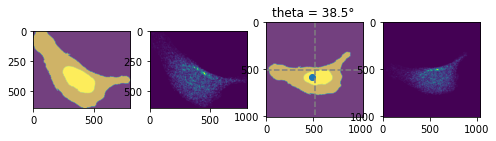

In [140]:
#center_of_mass(nuclei_), nuclei_.shape, theta
nuclei = data[1, :, :]
cell = data[0, :, :]
region = regionprops(cell)[0]
theta = region.orientation * (180 / np.pi) # radiant to degree conversion
c = region.centroid
theta = 90- theta
cell_ = rotate(cell, theta)#, center=(c[1],c[0]), clip=False) # rotate counter-clockwise by theta
nuclei_ = rotate(nuclei, theta)#, center=(c[1],c[0]), clip=False)
center_ = center_of_mass(cell_)
print(c, center_)
print(region.orientation,90-theta, 180 / np.pi)

shape = nuclei_.shape

# NOTE: np.rot90() flip counter-clockwise
if center_[0] < shape[0]//2: # flip along axis 0 = rotating xx degre
    cell_ = rotate(cell_,90)
    nuclei_ = rotate(nuclei_,90)
    theta += 90

protein_ch_ = rotate(pro, theta)
if True:
    center_ = center_of_mass(cell_)
    fig, ax = plt.subplots(1, 4, figsize=(8, 4))
    ax[0].imshow(nuclei, alpha=0.5)
    ax[0].imshow(cell, alpha=0.5)
    ax[1].imshow(pro)
    ax[2].set_title(f"theta = {np.round(theta,1)}° ")
    ax[2].imshow(nuclei_, alpha=0.5)
    ax[2].imshow(cell_, alpha=0.5)
    ax[2].scatter(center_[1],center_[0])
    ax[2].vlines(shape[1]//2, 0, shape[0]-1, colors='gray', linestyles ='dashed') 
    ax[2].hlines(shape[0]//2, 0, shape[1]-1, colors='gray', linestyles ='dashed') 
    ax[3].imshow(protein_ch_)

In [126]:
380 % 360

20

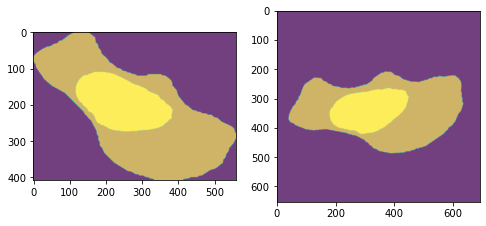

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(nuclei, alpha=0.5)
ax[0].imshow(cell, alpha=0.5)
ax[1].imshow(nuclei_, alpha=0.5)
ax[1].imshow(cell_, alpha=0.5)

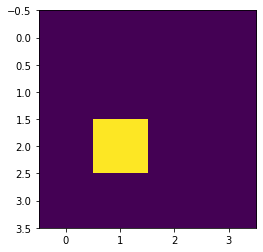

In [56]:
A = np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]])
if center_[0] < shape[0]//2: # flip along axis 0
    cell_ = np.rot90(cell_,1)
    nuclei_ = np.rot90(nuclei_,1)
    theta += 90
if center_[1] < shape[1]//2: # flip along axis 1
    cell_ = np.rot90(cell_,1)
    nuclei_ = np.rot90(nuclei_,1)
    theta += 90

plt.imshow(np.rot90(A, -1))